
# Анализ запросов Яндекс.Картинок по платформам

## 🎯 Цель исследования
Проверим гипотезу: **интересы пользователей, использующих Яндекс.Картинки на мобильных устройствах и на компьютерах, заметно отличаются**.

## 1. 📦 Загрузка и первичный осмотр данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import plotly.express as px
import plotly.graph_objects as go
from pandasql import sqldf

In [2]:
# Загрузка файла
df= pd.read_csv('data.tsv', sep='\t')

# Просомтр первых строк
df.head()

,порно фото,1631786697,touch
0,малевич картины,1631806465,desktop
1,Секс,1631781583,touch
2,с днём рождения лена,1631771563,touch
3,зверополис порно,1631787599,touch
4,алабай собака фото,1631786645,touch


In [3]:
# Загрузка без заголовка
df = pd.read_csv('data.tsv', sep='\t', header=None, names=['query', 'timestamp', 'platform'])

# Преобразуем timestamp в datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df['date'] = df['timestamp'].dt.date
df['hour'] = df['timestamp'].dt.hour
df['weekday'] = df['timestamp'].dt.day_name()

# Проверим
df.head()

,query,timestamp,platform,date,hour,weekday
0,порно фото,2021-09-16 10:04:57,touch,2021-09-16,10,Thursday
1,малевич картины,2021-09-16 15:34:25,desktop,2021-09-16,15,Thursday
2,Секс,2021-09-16 08:39:43,touch,2021-09-16,8,Thursday
3,с днём рождения лена,2021-09-16 05:52:43,touch,2021-09-16,5,Thursday
4,зверополис порно,2021-09-16 10:19:59,touch,2021-09-16,10,Thursday


## 2. 🗓 Диапазон дат в выборке

In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df['date'] = df['timestamp'].dt.date

print("Минимальная дата:", df['date'].min())
print("Максимальная дата:", df['date'].max())

Минимальная дата: 2021-08-31
Максимальная дата: 2021-09-21


## 3. 🔎 Частота запросов с упоминанием "ютуб"

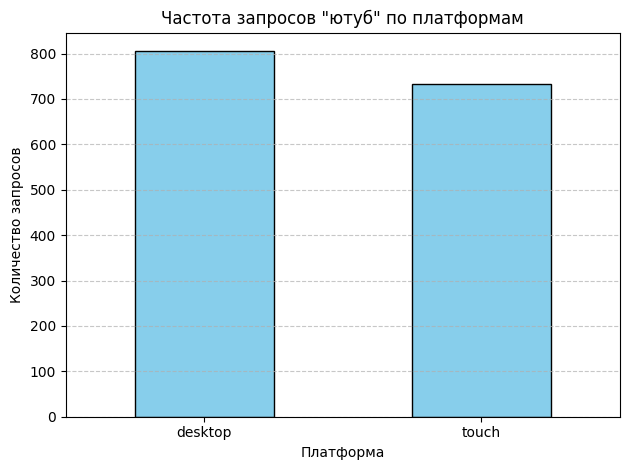

In [5]:
df['query_lower'] = df['query'].str.lower()
youtube_df = df[df['query_lower'].str.contains('ютуб', na=False)]
youtube_counts = youtube_df['platform'].value_counts()

# Построим график с подписями
ax = youtube_counts.plot(kind='bar', title='Частота запросов "ютуб" по платформам', color='skyblue', edgecolor='black')
ax.set_xlabel('Платформа')
ax.set_ylabel('Количество запросов')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Вывод ✍️**: Частота запросов, содержащих слово "ютуб", оказалась схожей на обеих платформах. Тем не менее, с компьютеров такие запросы совершаются немного чаще (примерно на 10% больше), чем с мобильных устройств.

## 4. 🏆 Топ-10 самых частых запросов по платформам

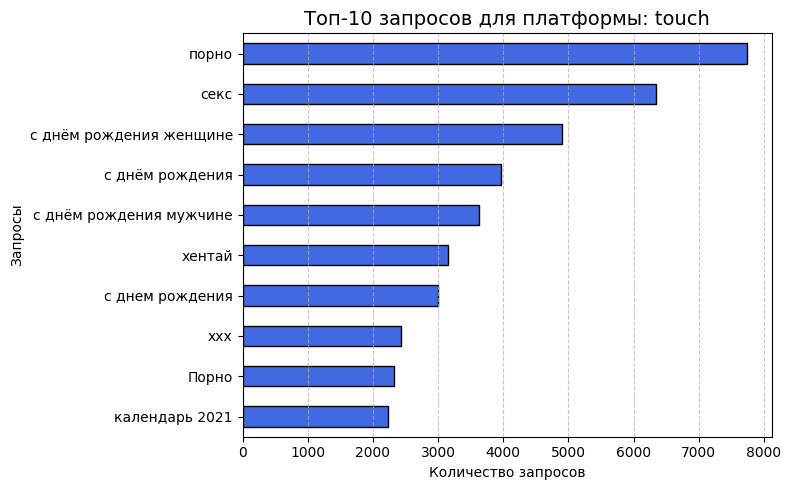

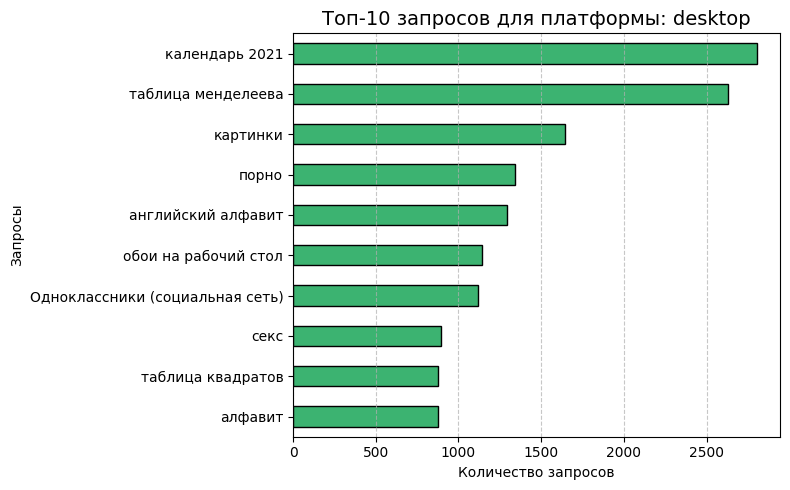

In [6]:
# Цвета для платформ
platform_colors = {
    'desktop': 'mediumseagreen',
    'touch': 'royalblue'
}

platforms = df['platform'].unique()

for platform in platforms:
    top10_platform = df[df['platform'] == platform]['query'].value_counts().nlargest(10)
    
    plt.figure(figsize=(8, 5))
    top10_platform.plot(
        kind='barh',
        color=platform_colors.get(platform, 'gray'),
        edgecolor='black'
    )
    
    plt.title(f'Топ-10 запросов для платформы: {platform}', fontsize=14)
    plt.xlabel('Количество запросов')
    plt.ylabel('Запросы')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.gca().invert_yaxis()  # чтобы самый популярный был сверху
    plt.tight_layout()
    plt.show()

**📱 Мобильные устройства (touch)**:
1. Доминируют запросы сексуального и развлекательного характера: «порно», «секс», «хентай», «xxx» — они занимают почти половину топа.
2. Много запросов про поздравления — с «днём рождения женщине», мужчине и просто.
3. Общий стиль запросов — эмоциональный, личный, быстрый.
Люди как будто ищут что-то «по ситуации»: развлечься, поздравить, отреагировать на событие.

**🖥 Компьютеры (desktop)**:
1. На первом месте — утилитарные и учебные темы: «календарь 2021», «таблица Менделеева», «английский алфавит», «таблица квадратов».
2. Присутствуют оформительские и рабочие запросы: «обои на рабочий стол», «одноклассники».
3. Темы — образование, оформление, информация. Видно, что пользователь чаще ищет что-то для учебы, офиса, или скачивания.

**Вывод ✍️**: 
Пользователи мобильных устройств чаще делают эмоционально окрашенные и развлекательные запросы, связанные с темами интимного характера и поздравлений.
В то время как пользователи компьютеров склонны искать утилитарную и образовательную информацию — таблицы, календари, справочные материалы.
Это может отражать различие в контексте использования: мобильные — спонтанный поиск «на ходу», десктоп — более осмысленная работа или учеба.

## 5. 🕰️ Временная активность пользователей

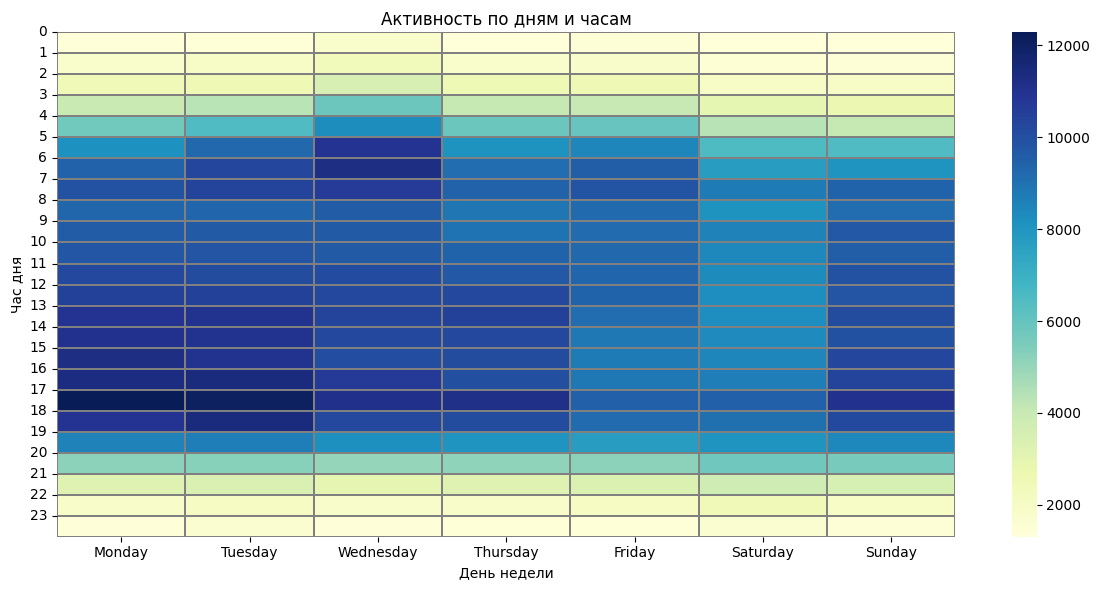

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Убедимся, что час и день недели есть
df['hour'] = df['timestamp'].dt.hour
df['weekday'] = df['timestamp'].dt.day_name()

# Пивот-таблица
pivot_heat = df.pivot_table(index='hour', columns='weekday', values='query', aggfunc='count')

# Порядок дней недели 
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_heat = pivot_heat[ordered_days]

# Построим график
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_heat.fillna(0), cmap='YlGnBu', linewidths=0.3, linecolor='gray')

plt.title('Активность по дням и часам')
plt.xlabel('День недели')
plt.ylabel('Час дня')
plt.yticks(ticks=range(24), labels=[str(h) for h in range(24)], rotation=0)
plt.tight_layout()
plt.show()

**Вывод ✍️**: 
1. Наибольшая активность пользователей наблюдается в дневное и вечернее время — с 5:00 до 20:00, причём запросов больше всего поступает во второй половине дня.
2. Пиковая нагрузка вне зависимости от дня недели приходится на промежуток с 17:00 до 20:00, что может быть связано с окончанием рабочего дня и активным использованием мобильных устройств в дороге или дома.
3. В ночные часы (с 22:00 до 3:00) происходит резкое снижение активности — почти полное затухание потока запросов, что соответствует времени сна основной аудитории.
4. Максимальная активность по дням недели наблюдается в понедельник и вторник, особенно в вечерние часы (с 17:00 до 19:00), что может отражать высокую вовлечённость пользователей в начале недели.
5. Минимум запросов приходится на пятницу и субботу, что, вероятно, связано с тем, что пользователи в эти дни чаще заняты офлайн-активностями, реже используют поиск по картинкам, особенно с компьютеров.
6. Воскресенье показывает умеренный рост активности — возможно, это связано с подготовкой к рабочей неделе и возвращением к регулярным цифровым сценариям.

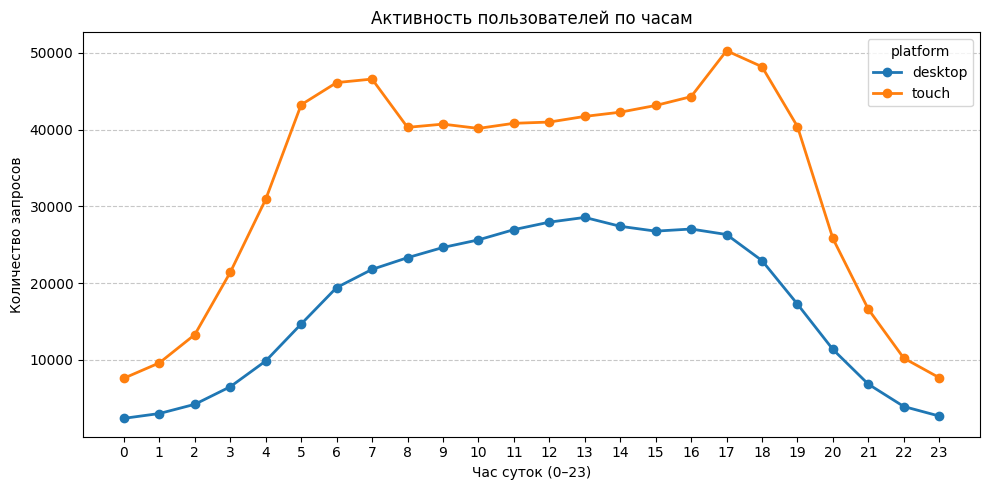

In [8]:
# Группировка: количество запросов по часу и платформе
pivot = df.pivot_table(index='hour', columns='platform', values='query', aggfunc='count')

# Построение графика
ax = pivot.plot(
    kind='line',
    figsize=(10, 5),
    marker='o',
    linewidth=2,
    title='Активность пользователей по часам'
)

# Подписи осей
ax.set_xlabel('Час суток (0–23)')
ax.set_ylabel('Количество запросов')

# Настройки оси X — все часы
ax.set_xticks(range(24))
ax.set_xticklabels(range(24))
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

**Вывод ✍️**: 
Общая динамика активности показывает, что запросы начинают поступать уже с 6–7 часов утра, достигают пика во второй половине дня и постепенно снижаются после 20:00.

**Мобильные пользователи (touch)** демонстрируют два выраженных пика активности:

1. Утренний — около 6–7 часов, что, вероятно, связано с использованием смартфонов по пути на работу или учёбу.
2. Вечерний — с 17 до 19 часов, когда пользователи возвращаются домой или находятся в более расслабленном состоянии.
3. Между этими пиками (с 8 до 16 часов) активность остаётся стабильной, что может отражать фоновое использование мобильных устройств в течение дня.

**Пользователи компьютеров (desktop)** проявляют более равномерную и продолжительную активность с 6 до 18 часов.
1. Наблюдается медленный рост до 13:00, далее — плато с 14 до 17, и плавное снижение к вечеру.
2. Это поведение похоже на типичный офисный или учебный график, где компьютеры используются в течение рабочего/учебного дня, а вечером отключаются.

**Сравнение платформ**:

- Общее количество запросов с мобильных устройств значительно выше, чем с десктопов — это указывает на доминирование мобильного поведения при использовании Яндекс.Картинок.
- Активность мобильных пользователей более "импульсная", с резкими пиками, тогда как десктоп — более стабильный и предсказуемый канал.

**Гипотеза**: различия могут быть связаны с контекстами использования:
- Мобильные устройства — для личного и спонтанного поиска, часто в движении или в свободное время.
- Десктопы — для целенаправленного поиска в рабочее/учебное время, с меньшей эмоциональной окраской.

## 6. 🤖 Кластеризация тематик запросов

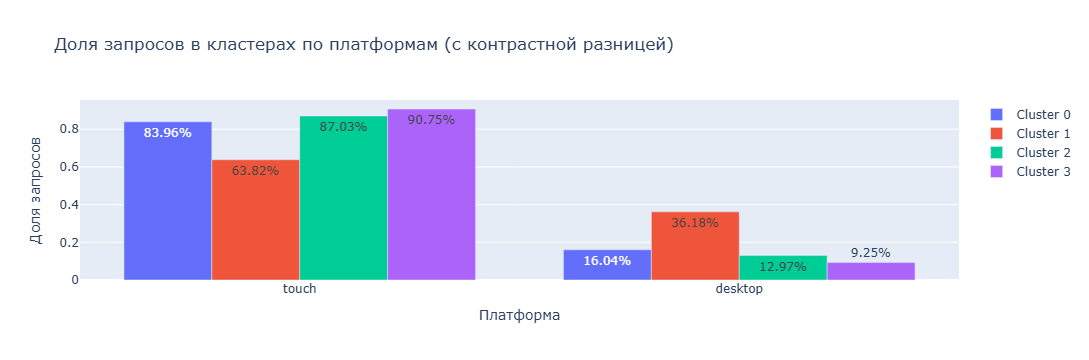

Ключевые слова в кластерах с заметной разницей по платформам:

Кластер 0:
хентай, наруто, лоли, манга, цензуры, без, геншин, яой, аниме, порно

Кластер 1:
картинки, секс, на, 2021, фото, сентября, для, карта, календарь, таблица

Кластер 2:
порно, фото, гей, аниме, гиф, гифки, наруто, картинки, лесби, мультики

Кластер 3:
рождения, днём, женщине, днем, мужчине, открытки, поздравления, девушке, красивые, картинки


In [9]:
# 1. Векторизация запросов
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['query_lower'])

# 2. Кластеризация
kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto')
df['cluster'] = kmeans.fit_predict(X)

# 3. Подсчёт распределения кластеров по платформам
cluster_platform_counts = df.groupby(['cluster', 'platform']).size().unstack(fill_value=0)
cluster_platform_props = cluster_platform_counts.div(cluster_platform_counts.sum(axis=1), axis=0)

# 4. Вычисляем абсолютную разницу в долях
cluster_platform_props['diff'] = (cluster_platform_props['touch'] - cluster_platform_props['desktop']).abs()

# 5. Фильтруем кластеры с разницей больше порога (например, 0.1)
threshold = 0.1
significant_diff = cluster_platform_props[cluster_platform_props['diff'] > threshold]

# 6. Визуализация в Plotly
fig = go.Figure()

for cluster_id in significant_diff.index:
    fig.add_trace(go.Bar(
        name=f'Cluster {cluster_id}',
        x=['touch', 'desktop'],
        y=significant_diff.loc[cluster_id, ['touch', 'desktop']],
        text=significant_diff.loc[cluster_id, ['touch', 'desktop']].apply(lambda x: f'{x:.2%}'),
        textposition='auto'
    ))

fig.update_layout(
    barmode='group',
    title='Доля запросов в кластерах по платформам (с контрастной разницей)',
    yaxis=dict(title='Доля запросов'),
    xaxis=dict(title='Платформа')
)

fig.show()

# 7. Вывести ключевые слова топ-10 для таких кластеров
terms = vectorizer.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

print("Ключевые слова в кластерах с заметной разницей по платформам:")
for i in significant_diff.index:
    print(f"\nКластер {i}:")
    top_words = [terms[ind] for ind in order_centroids[i, :10]]
    print(", ".join(top_words))

In [10]:
# Создадим словарь для хранения результатов
results = []

for i in significant_diff.index:
    top_words = [terms[ind] for ind in order_centroids[i, :10]]
    mobile_share = significant_diff.loc[i, 'touch']
    desktop_share = significant_diff.loc[i, 'desktop']
    diff_val = significant_diff.loc[i, 'diff']
    results.append({
        'cluster': i,
        'touch_share': mobile_share,
        'desktop_share': desktop_share,
        'diff': diff_val,
        'top_words': top_words
    })

# Превратим в читаемый текстовый формат
output_lines = []
for r in results:
    output_lines.append(f"Кластер {r['cluster']}:")
    output_lines.append(f"  Доля мобильных запросов: {r['touch_share']:.2%}")
    output_lines.append(f"  Доля десктопных запросов: {r['desktop_share']:.2%}")
    output_lines.append(f"  Абсолютная разница: {r['diff']:.2%}")
    output_lines.append(f"  Ключевые слова: {', '.join(r['top_words'])}")
    output_lines.append("")  # пустая строка для разделения

# Выведем в консоль
output_text = "\n".join(output_lines)
print(output_text)

Кластер 0:
  Доля мобильных запросов: 83.96%
  Доля десктопных запросов: 16.04%
  Абсолютная разница: 67.93%
  Ключевые слова: хентай, наруто, лоли, манга, цензуры, без, геншин, яой, аниме, порно

Кластер 1:
  Доля мобильных запросов: 63.82%
  Доля десктопных запросов: 36.18%
  Абсолютная разница: 27.65%
  Ключевые слова: картинки, секс, на, 2021, фото, сентября, для, карта, календарь, таблица

Кластер 2:
  Доля мобильных запросов: 87.03%
  Доля десктопных запросов: 12.97%
  Абсолютная разница: 74.07%
  Ключевые слова: порно, фото, гей, аниме, гиф, гифки, наруто, картинки, лесби, мультики

Кластер 3:
  Доля мобильных запросов: 90.75%
  Доля десктопных запросов: 9.25%
  Абсолютная разница: 81.51%
  Ключевые слова: рождения, днём, женщине, днем, мужчине, открытки, поздравления, девушке, красивые, картинки



**Вывод ✍️**: 

**Кластер 0** (мобильные 84%, десктоп 16%)
- Тематика: Аниме, хентай, манга, геншин, яой, лоли, цензура, порно.
- Вывод: Это явно нишевые развлекательные запросы, которые пользователи предпочитают делать именно с мобильных — возможно, из-за приватности или удобства. На десктопе они встречаются значительно реже.

**Кластер 1**(мобильные 64%, десктоп 36%)
- Тематика: Картинки, фото, секс, календарь, таблицы — более общий контент, связанный с поиском визуального и информационного материала.
- Вывод: Здесь разрыв меньше, но мобильные запросы всё равно преобладают. Вероятно, мобильные пользователи чаще ищут быстрый визуальный или справочный контент.

**Кластер 2** (мобильные 87%, десктоп 13%)
- Тематика: Порно, гей, аниме, гифки, лесби, мультики — опять тематика взрослого и анимационного контента, очень мобильная.
- Вывод: Сильно выраженная мобильная аудитория, скорее всего по тем же причинам, что и в кластере 0 — удобство и приватность.

**Кластер 3** (мобильные 91%, десктоп 9%)
- Тематика: Поздравления с днём рождения, открытки, пожелания — типичный контент для личного использования.
- Вывод: Запросы с поздравлениями сильно мобильные — удобно быстро отправить поздравление с телефона, поэтому здесь тоже большая разница.

**Общие выводы:**
1. Темы, связанные с личным, развлекательным, иногда приватным контентом (аниме, порно, поздравления), значительно более популярны на мобильных устройствах.
2. Более нейтральный или информационный контент (например, картинки, таблицы) менее контрастен, но всё равно мобильный трафик выше.
3. На десктопе либо контент более профессиональный, либо менее "эмоциональный", однако в целом мобильная аудитория активнее в части визуального и справочного контента.

## 7. 🧠 SQL-запросы через pandasql

In [11]:
# 1. Сколько запросов с упоминанием "ютуб" по платформам
query = '''
SELECT platform, COUNT(*) as cnt
FROM df
WHERE query_lower LIKE '%ютуб%'
GROUP BY platform
'''
sqldf(query)

,platform,cnt
0,desktop,806
1,touch,732


In [12]:
# 2. Сколько запросов по каждому дню недели на каждой платформе
query = '''
SELECT weekday, platform, COUNT(*) as cnt
FROM df
GROUP BY weekday, platform
ORDER BY cnt DESC
'''
sqldf(query)

,weekday,platform,cnt
0,Wednesday,touch,124037
1,Tuesday,touch,118307
2,Monday,touch,114627
3,Sunday,touch,112629
4,Thursday,touch,109555
5,Friday,touch,107569
6,Saturday,touch,105534
7,Tuesday,desktop,66687
8,Monday,desktop,65723
9,Wednesday,desktop,61970


In [13]:
# 3. Топ-5 самых частых запросов на десктопе
query = '''
SELECT query_lower, COUNT(*) as cnt
FROM df
WHERE platform = 'desktop'
GROUP BY query_lower
ORDER BY cnt DESC
LIMIT 5
'''
sqldf(query)

,query_lower,cnt
0,календарь 2021,2810
1,таблица менделеева,2659
2,картинки,1720
3,порно,1408
4,английский алфавит,1352


## 8. 📝 Выводы

В ходе исследования подтверждена гипотеза о заметных различиях в интересах и поведении пользователей Яндекс.Картинок в зависимости от платформы — мобильной (touch) или десктопной (desktop).

**Тематические различия**
1. <u>Мобильные пользователи</u> делают акцент на *эмоционально окрашенных, личных и развлекательных запросах*:
- Тематики интимного характера (порно, секс, хентай), поздравления, открытки.
- Запросы часто «по ситуации» — быстрый поиск для развлечения, поздравления или эмоциональной реакции.
- В кластеризации выделены кластеры с преобладанием именно таких тем (до 84-91% на мобильных).

2. <u>Пользователи компьютеров</u> преимущественно интересуются *утилитарным, образовательным и справочным контентом*:
- Календарь, таблицы, алфавиты, обои, учебные материалы.
- Запросы более формальные, связаны с учёбой, работой и оформлением.
- На десктопе значительно более выражена доля запросов без эмоциональной составляющей. 

**Временные паттерны активности**
- Активность пользователей распределена неравномерно в течение суток и недели.
- Основной пик запросов приходится на дневное и вечернее время — с 5:00 до 20:00, особенно в период с 17:00 до 20:00.
- <u>Мобильные пользователи</u> демонстрируют два ярких пика — утренний (6–7 часов) и вечерний (17–19 часов), что, вероятно,  связано с мобильным использованием в пути между работой и домом. 
- <u>Пользователи десктопов</u> проявляют более равномерную дневную активность, соответствующую офисному или учебному расписанию (с 6 до 18 часов).
- Активность снижается в ночные часы (22:00–3:00), а минимумы по дням недели наблюдаются в пятницу и субботу, что, вероятно, связано с офлайн-активностями.

**Поведенческие выводы**
1. <u>Мобильное использование</u> Яндекс.Картинок — это, в основном, *импульсивный, эмоциональный и спонтанный поиск*, отражающий личные и развлекательные потребности.
2. <u>Компьютерное использование</u> — более *осмысленное, целенаправленное, связанное с учёбой, работой и получением справочной информации*.

**Рекомендации и значение**
При разработке продуктов, контента и маркетинговых стратегий важно учитывать эти различия:
- <u>Для мобильных пользователей</u> — упор на развлекательный и личный контент, быструю отдачу и эмоциональную вовлечённость.
- <u>Для десктопа</u> — информационный и образовательный контент с более формальной подачей.

Временные паттерны активности помогут оптимизировать время публикаций и рекламных кампаний.